In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from pprint import pprint
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes

from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)

from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,population_cat,housing_median_age_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,1,3,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,4,2,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,2,3,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,1,4,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,2,4,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  population_cat            17564 non-null  int64   
 12  housing_median_age_cat    17564 non-null  int64   
 13  rooms_per_household       17564 non-null  floa

In [4]:
# df['median_income_cat'] = pd.Categorical(df['median_income_cat'], ordered=True)
# df['population_cat'] = pd.Categorical(df['population_cat'], ordered=True)
# df['housing_median_age_cat'] = pd.Categorical(df['housing_median_age_cat'], ordered=True)

colunas_exluir = ['population_cat', 'housing_median_age_cat',]

df.drop(columns=colunas_exluir, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [5]:
coluna_target = ['median_house_value',]

coluna_one_hot_encoder = ['ocean_proximity',]

coluna_ordinal_encoder = ['median_income_cat',] # + colunas_exluir

In [6]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder).to_list()
print('colunas_robust_scaler =', colunas_robust_scaler)

colunas_robust_scaler = ['bedrooms_per_room', 'households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'population', 'population_per_household', 'rooms_per_household', 'total_bedrooms', 'total_rooms']


In [7]:
pipeline_robust = Pipeline(steps=[
    ('robust_scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
])

preprocessamento = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_encoder),
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ('robust_scaler_poly', pipeline_robust, colunas_robust_scaler),
    ],
)

preprocessamento


ColumnTransformer(transformers=[('ordinal_encoder', OrdinalEncoder(),
                                 ['median_income_cat']),
                                ('one_hot', OneHotEncoder(drop='first'),
                                 ['ocean_proximity']),
                                ('robust_scaler_poly',
                                 Pipeline(steps=[('robust_scaler',
                                                  RobustScaler()),
                                                 ('poly',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False))]),
                                 ['bedrooms_per_room', 'households',
                                  'housing_median_age', 'latitude', 'longitude',
                                  'median_income', 'population',
                                  'population_per_household',
                                  'rooms_per_household', 'total_bedrooms',
                                  'total_rooms'])])

In [8]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [9]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [10]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [12]:
param_grid = {
    'regressor__preprocessor__robust_scaler_poly__poly__degree': [1, 2, 3,],
}

param_grid

{'regressor__preprocessor__robust_scaler_poly__poly__degree': [1, 2, 3]}

In [13]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution='normal'),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                                                               'rooms_per_household',
                                                                                                               'total_bedrooms',
                                                                                                               'total_rooms'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [14]:
X[['longitude', 'latitude', 'rooms_per_household', 'population_per_household', 'bedrooms_per_room', 'median_income',]] =\
    X[['longitude', 'latitude', 'rooms_per_household', 'population_per_household', 'bedrooms_per_room', 'median_income',]]\
        .astype(np.float64, copy=True)
X[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households',]] =\
    X[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households',]].astype(np.int64, copy=True)

X.info()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float64 
 1   latitude                  17564 non-null  float64 
 2   housing_median_age        17564 non-null  int64   
 3   total_rooms               17564 non-null  int64   
 4   total_bedrooms            17564 non-null  int64   
 5   population                17564 non-null  int64   
 6   households                17564 non-null  int64   
 7   median_income             17564 non-null  float64 
 8   ocean_proximity           17564 non-null  category
 9   median_income_cat         17564 non-null  int64   
 10  rooms_per_household       17564 non-null  float64 
 11  population_per_household  17564 non-null  float64 
 12  bedrooms_per_room         17564 non-null  float64 
dtypes: category(1), float64(6), int64(6)
memory us

In [15]:
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                                                               'rooms_per_household',
                                                                                                               'total_bedrooms',
                                                                                                               'total_rooms'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [16]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3}

In [17]:
grid_search.best_score_

np.float64(-51235.856080386795)

In [18]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__households population_per_household total_rooms,-2.189816e+06
robust_scaler_poly__bedrooms_per_room households,-1.885270e+06
robust_scaler_poly__households^2 rooms_per_household,-1.831078e+06
robust_scaler_poly__population rooms_per_household total_bedrooms,-1.109135e+06
robust_scaler_poly__population total_bedrooms,-1.045982e+06
...,...
robust_scaler_poly__population_per_household total_bedrooms total_rooms,1.101983e+06
robust_scaler_poly__households rooms_per_household total_bedrooms,1.368396e+06
robust_scaler_poly__households^2 population_per_household,1.598981e+06
robust_scaler_poly__households population rooms_per_household,2.003668e+06


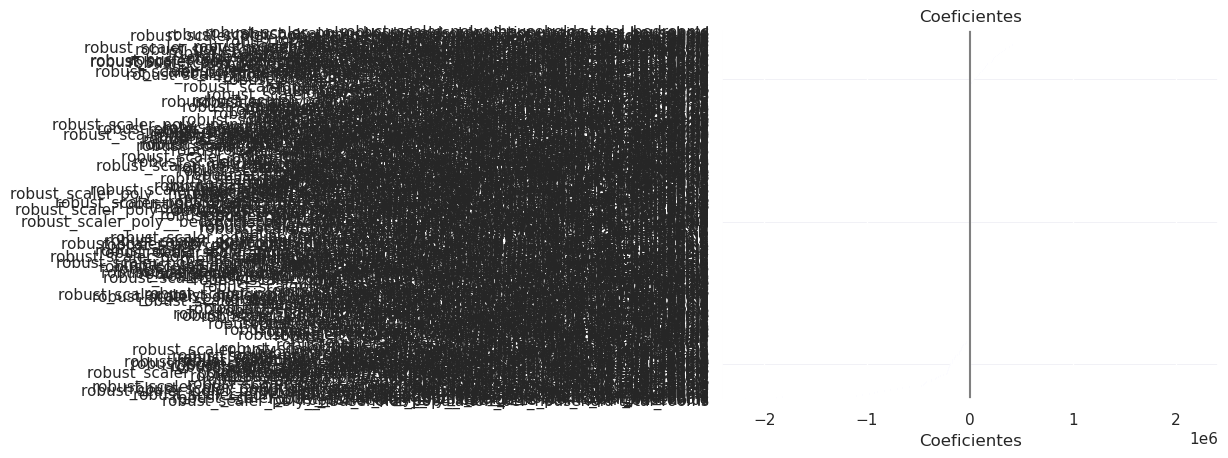

In [19]:
plot_coeficientes(coefs)

In [20]:
coefs[coefs['coeficiente']==0].head()

,coeficiente


In [23]:
coefs[coefs['coeficiente'].between(-100_000, 100_000)]

,coeficiente
robust_scaler_poly__median_income population,-93097.525009
robust_scaler_poly__rooms_per_household^2,-87545.231875
robust_scaler_poly__bedrooms_per_room housing_median_age total_rooms,-84354.610200
robust_scaler_poly__bedrooms_per_room longitude total_rooms,-83184.223240
robust_scaler_poly__longitude total_rooms,-73891.785985
...,...
robust_scaler_poly__rooms_per_household total_bedrooms,59934.646819
robust_scaler_poly__housing_median_age rooms_per_household,66265.267009
robust_scaler_poly__bedrooms_per_room,79014.900935
robust_scaler_poly__bedrooms_per_room rooms_per_household total_rooms,86433.811835


In [20]:
regressors = {
    'LinearRegression': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },

    'LinearRegression_grid_search': {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer_,
    },
}

In [ ]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X=X, y=y, **regressor)
        for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

In [ ]:
df_resultados.groupby('model').mean().T

In [ ]:
plot_comparar_metricas_modelos(df_resultados)

In [ ]:
plot_residuos_estimador(
    estimator=grid_search.best_estimator_,
    X=X,
    y=y,
    eng_formatter=True,
    fracao_amostra=0.1,
)